--- Starting Feature Engineering & Model Prototyping Notebook ---
Loading engineered data...
Engineered data loaded successfully.

E-commerce Data Head:
   user_id          signup_time  purchase_value      device_id  source browser sex  age    ip_address  class  ip_address_int        country  hour_of_day  day_of_week  day_of_year  month  year  time_since_signup_seconds  user_transactions_24hr  user_value_24hr_sum  device_transactions_24hr  device_value_24hr_sum
0        2  2015-01-11 03:47:13              54  FGBQNDNBETFJJ     SEO  Chrome   F   25  8.802175e+08      0       880217484  United States           10            5           52      2  2015                  3564984.0                     1.0                 54.0                       1.0                   54.0
1        4  2015-06-02 16:40:57              41  MKFUIVOHLJBYN  Direct  Safari   F   38  2.785906e+09      0      2785906106    Switzerland           21            5          269      9  2015                 10039879.0   

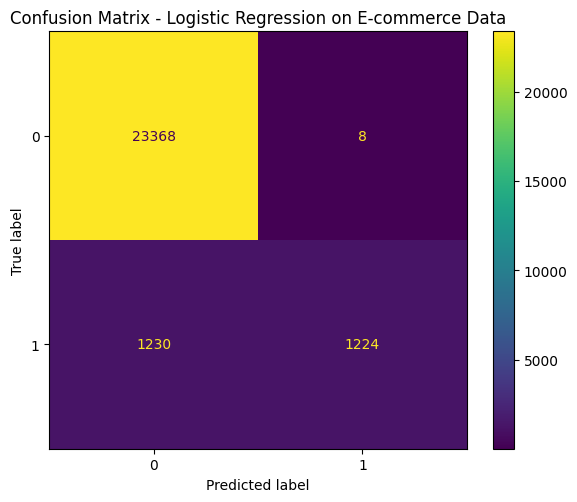

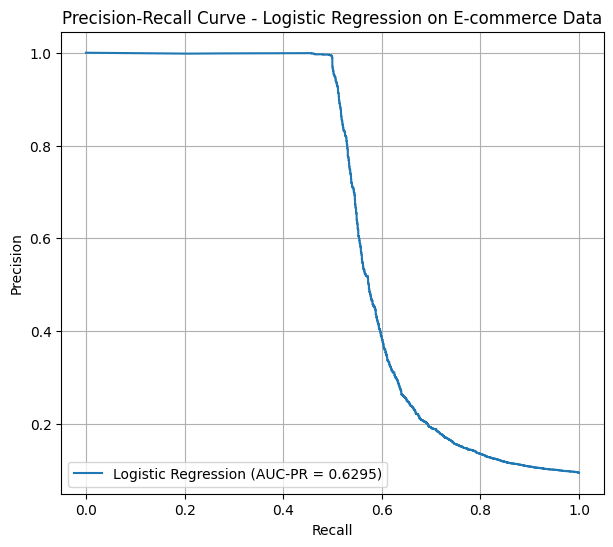


--- Training LightGBM for E-commerce Data ---
[LightGBM] [Info] Number of positive: 93502, number of negative: 93502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.821234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51013
[LightGBM] [Info] Number of data points in the train set: 187004, number of used features: 3748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- LightGBM Performance on E-commerce Data ---
F1-Score: 0.7099
AUC-PR: 0.6466
Confusion Matrix:
 [[23375     1]
 [ 1103  1351]]


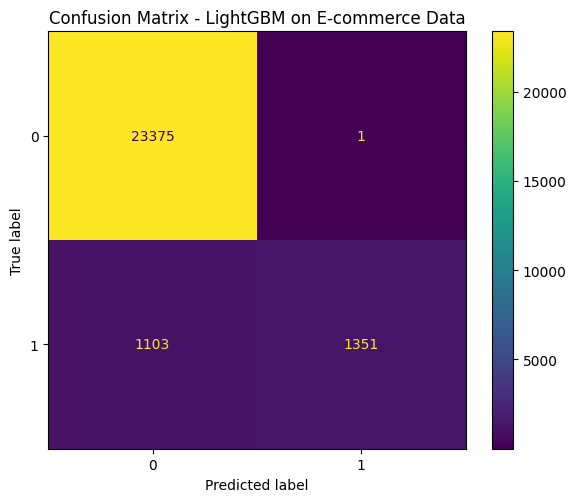

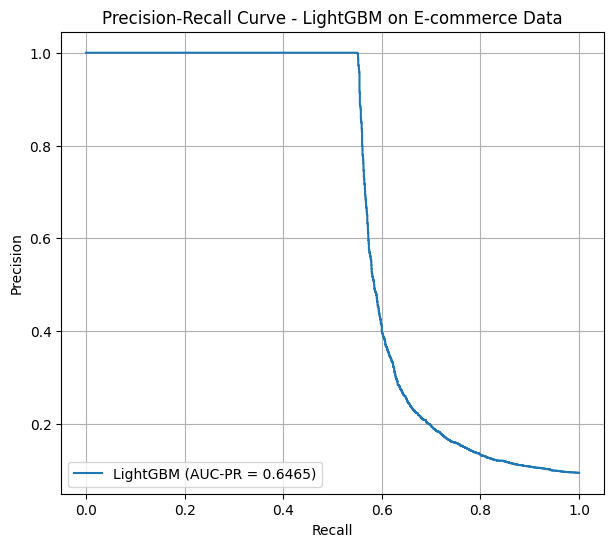


--- Training Logistic Regression for Bank Data ---

--- Logistic Regression Performance on Bank Data ---
F1-Score: 0.0995
AUC-PR: 0.6734
Confusion Matrix:
 [[55161  1490]
 [   12    83]]


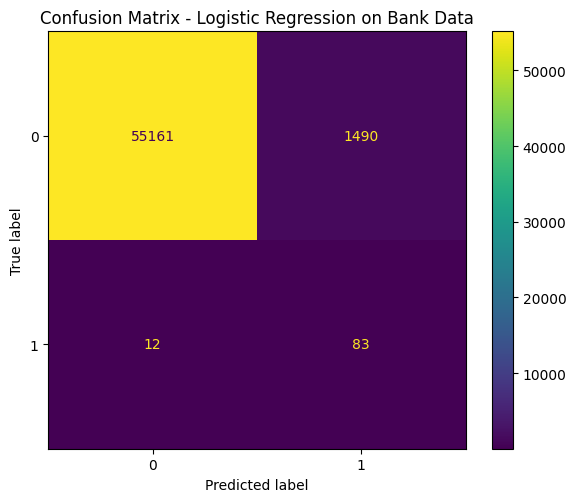

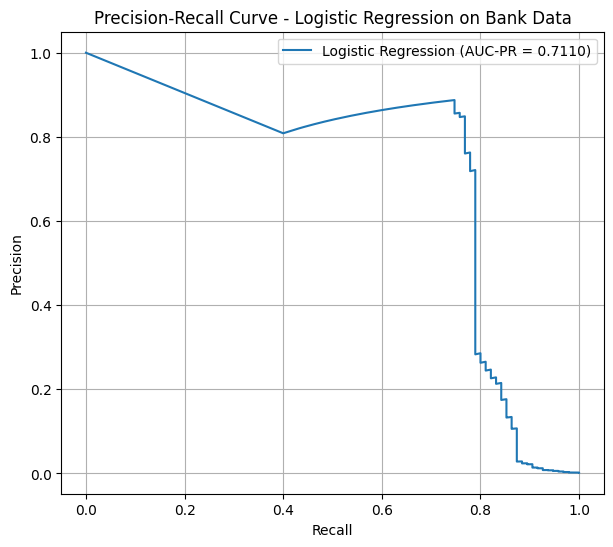


--- Training LightGBM for Bank Data ---
[LightGBM] [Info] Number of positive: 226602, number of negative: 226602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 453204, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- LightGBM Performance on Bank Data ---
F1-Score: 0.6638
AUC-PR: 0.7477
Confusion Matrix:
 [[56589    62]
 [   17    78]]


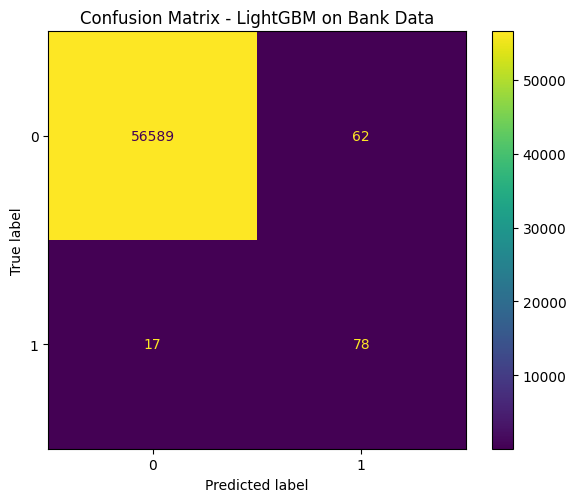

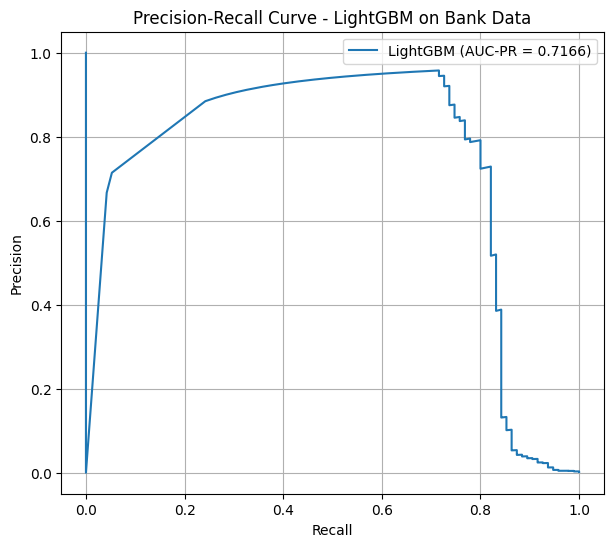


--- Hyperparameter Tuning Example: LightGBM for E-commerce Data ---
Fitting GridSearchCV (this may take some time)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/home/fentahun/10_acadamy/fraud_detection_week_8-9/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[LightGBM] [Info] Number of positive: 62335, number of negative: 62335
[LightGBM] [Info] Number of positive: 62335, number of negative: 62335
[LightGBM] [Info] Number of positive: 62335, number of negative: 62335
[LightGBM] [Info] Number of positive: 62335, number of negative: 62335
[LightGBM] [Info] Number of positive: 62335, number of negative: 62335
[LightGBM] [Info] Number of positive: 62334, number of negative: 62334
[LightGBM] [Info] Number of positive: 62334, number of negative: 62334
[LightGBM] [Info] Number of positive: 62335, number of negative: 62335
[LightGBM] [Info] Number of positive: 62334, number of negative: 62334
[LightGBM] [Info] Number of positive: 62335, number of negative: 62335
[LightGBM] [Info] Number of positive: 62335, number of negative: 62335
[LightGBM] [Info] Number of positive: 62334, number of negative: 62334
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 204.107945 seconds.
You can set `force_row_wise=true` to remov

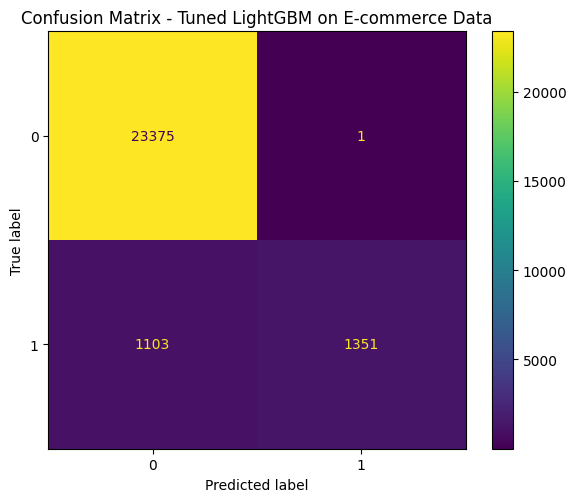

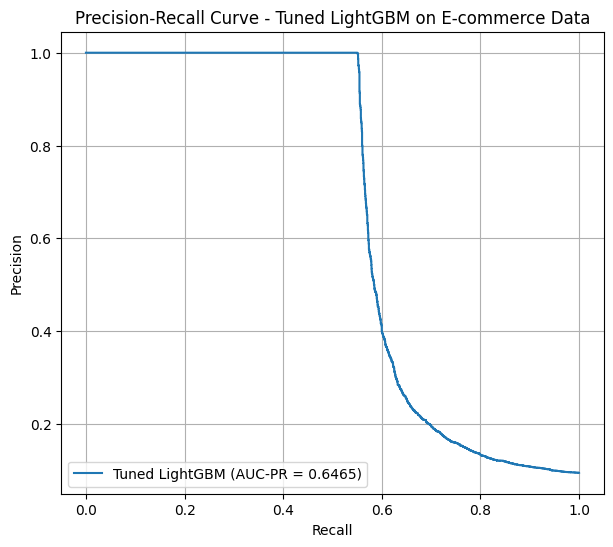

{'f1_score': 0.7099316868102995,
 'auc_pr': 0.6465630046039006,
 'confusion_matrix': array([[23375,     1],
        [ 1103,  1351]])}

In [1]:
# Cell 1: Markdown
# # Feature Engineering and Model Prototyping

# This notebook serves as a workspace for:
# 1.  Refining feature engineering ideas beyond the basic steps.
# 2.  Experimenting with data transformation techniques (scaling, encoding).
# 3.  Testing different strategies for handling class imbalance.
# 4.  Prototyping and evaluating initial machine learning models (Logistic Regression, LightGBM)
# 5.  Exploring hyperparameter tuning with GridSearchCV.

# The goal here is to iterate quickly and gain insights that inform the final, formalized code in the `src/` directory.

# Cell 2: Code
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import (
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    average_precision_score, precision_recall_curve, auc, make_scorer
)
from collections import Counter
import joblib # For saving/loading preprocessors or pipelines
import sys

# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Define paths
PROCESSED_DATA_PATH = '../data/processed/' # Relative path from notebooks/
MODELS_PATH = '../models/'
REPORTS_PATH = '../reports/'

# Create directories if they don't exist
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)

print("--- Starting Feature Engineering & Model Prototyping Notebook ---")

# Cell 3: Markdown
# ## 1. Load Engineered Data

# We'll load the data that has already undergone basic cleaning and initial feature engineering from the previous `src/` scripts.

# Cell 4: Code
print("Loading engineered data...")
try:
    fraud_data_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'fraud_data_engineered.csv'))
    creditcard_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'creditcard_engineered.csv'))
    print("Engineered data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading engineered file: {e}. Please ensure 'src/feature_engineering.py' has been run successfully.")

print("\nE-commerce Data Head:")
print(fraud_data_df.head())
print("\nBank Data Head:")
print(creditcard_df.head())

# Cell 5: Markdown
# ## 2. Data Preparation for Modeling

# This involves separating features (X) from the target (y) and performing a train-test split. We will also define our preprocessing steps.

# Cell 6: Code
# --- E-commerce Data Preparation ---
print("\n--- Preparing E-commerce Data for Modeling ---")
X_ecommerce = fraud_data_df.drop(columns=['class', 'user_id', 'device_id', 'ip_address']) # Drop target and identifiers
y_ecommerce = fraud_data_df['class']

X_train_eco, X_test_eco, y_train_eco, y_test_eco = train_test_split(
    X_ecommerce, y_ecommerce, test_size=0.2, random_state=42, stratify=y_ecommerce
)

print("E-commerce Data Class distribution (train/test):")
print(f"Train: {Counter(y_train_eco)}")
print(f"Test: {Counter(y_test_eco)}")

# Define preprocessing steps for E-commerce data
numerical_features_eco = X_ecommerce.select_dtypes(include=np.number).columns
categorical_features_eco = X_ecommerce.select_dtypes(include=['object', 'bool']).columns

preprocessor_eco = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_eco),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_eco)
    ],
    remainder='passthrough'
)

# --- Bank Data Preparation ---
print("\n--- Preparing Bank Data for Modeling ---")
X_bank = creditcard_df.drop(columns=['Class']) # Drop target
y_bank = creditcard_df['Class']

X_train_bank, X_test_bank, y_bank_train, y_bank_test = train_test_split(
    X_bank, y_bank, test_size=0.2, random_state=42, stratify=y_bank
)

print("Bank Data Class distribution (train/test):")
print(f"Train: {Counter(y_bank_train)}")
print(f"Test: {Counter(y_bank_test)}")

# Define preprocessing steps for Bank data (all features are numerical except target)
numerical_features_bank = X_bank.select_dtypes(include=np.number).columns
categorical_features_bank = X_bank.select_dtypes(include=['object', 'bool']).columns # Should be empty

preprocessor_bank = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_bank),
        # No categorical features for bank data, but keep for consistency
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_bank) 
    ],
    remainder='passthrough'
)

# Cell 7: Markdown
# ## 3. Model Prototyping and Evaluation

# We will prototype Logistic Regression and LightGBM models. This section will also demonstrate how to use `imblearn.pipeline` to integrate sampling techniques like SMOTE.

# **Evaluation Function (same as in `src/model_training.py` for consistency):**

# Cell 8: Code
def evaluate_model(y_true, y_pred, y_prob, model_name, dataset_name):
    """Evaluates a classification model using F1-score, AUC-PR, and Confusion Matrix."""
    print(f"\n--- {model_name} Performance on {dataset_name} ---")

    f1 = f1_score(y_true, y_pred)
    print(f"F1-Score: {f1:.4f}")

    pr_auc = average_precision_score(y_true, y_prob)
    print(f"AUC-PR: {pr_auc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Plot Confusion Matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    cmp.plot(ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name} on {dataset_name}')
    plt.tight_layout()
    plt.show() # In notebook, show directly

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_curve_auc = auc(recall, precision)

    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, label=f'{model_name} (AUC-PR = {pr_curve_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name} on {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show() # In notebook, show directly

    return {'f1_score': f1, 'auc_pr': pr_auc, 'confusion_matrix': cm}

# Cell 9: Markdown
# ### 3.1. E-commerce Data Models

# Cell 10: Code
print("\n--- Training Logistic Regression for E-commerce Data ---")
lr_pipeline_eco = ImbPipeline(steps=[('preprocessor', preprocessor_eco),
                                    ('sampler', SMOTE(random_state=42)),
                                    ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000))])

lr_pipeline_eco.fit(X_train_eco, y_train_eco)

y_pred_lr_eco = lr_pipeline_eco.predict(X_test_eco)
y_prob_lr_eco = lr_pipeline_eco.predict_proba(X_test_eco)[:, 1]

evaluate_model(y_test_eco, y_pred_lr_eco, y_prob_lr_eco, 'Logistic Regression', 'E-commerce Data')

print("\n--- Training LightGBM for E-commerce Data ---")
lgbm_pipeline_eco = ImbPipeline(steps=[('preprocessor', preprocessor_eco),
                                       ('sampler', SMOTE(random_state=42)),
                                       ('classifier', lgb.LGBMClassifier(random_state=42, objective='binary', is_unbalance=True))])

lgbm_pipeline_eco.fit(X_train_eco, y_train_eco)

y_pred_lgbm_eco = lgbm_pipeline_eco.predict(X_test_eco)
y_prob_lgbm_eco = lgbm_pipeline_eco.predict_proba(X_test_eco)[:, 1]

evaluate_model(y_test_eco, y_pred_lgbm_eco, y_prob_lgbm_eco, 'LightGBM', 'E-commerce Data')

# Cell 11: Markdown
# ### 3.2. Bank Data Models

# Cell 12: Code
print("\n--- Training Logistic Regression for Bank Data ---")
lr_pipeline_bank = ImbPipeline(steps=[('preprocessor', preprocessor_bank),
                                    ('sampler', SMOTE(random_state=42)),
                                    ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000))])

lr_pipeline_bank.fit(X_train_bank, y_bank_train)

y_pred_lr_bank = lr_pipeline_bank.predict(X_test_bank)
y_prob_lr_bank = lr_pipeline_bank.predict_proba(X_test_bank)[:, 1]

evaluate_model(y_bank_test, y_pred_lr_bank, y_prob_lr_bank, 'Logistic Regression', 'Bank Data')


print("\n--- Training LightGBM for Bank Data ---")
lgbm_pipeline_bank = ImbPipeline(steps=[('preprocessor', preprocessor_bank),
                                       ('sampler', SMOTE(random_state=42)),
                                       ('classifier', lgb.LGBMClassifier(random_state=42, objective='binary', is_unbalance=True))])

lgbm_pipeline_bank.fit(X_train_bank, y_bank_train)

y_pred_lgbm_bank = lgbm_pipeline_bank.predict(X_test_bank)
y_prob_lgbm_bank = lgbm_pipeline_bank.predict_proba(X_test_bank)[:, 1]

evaluate_model(y_bank_test, y_pred_lgbm_bank, y_prob_lgbm_bank, 'LightGBM', 'Bank Data')

# Cell 13: Markdown
# ## 4. Hyperparameter Tuning Experiment (Example using GridSearchCV for LightGBM)

# This section demonstrates how you might experiment with hyperparameter tuning. Note that full-scale hyperparameter tuning can be computationally expensive.

# **Note:** Running this section might take significant time depending on your hardware and the size of the parameter grid. You might want to run this on a smaller subset of data or with fewer cross-validation folds for quicker prototyping.

# Cell 14: Code
print("\n--- Hyperparameter Tuning Example: LightGBM for E-commerce Data ---")

# Define a scoring metric for GridSearchCV (AUC-PR is excellent for imbalanced data)
scorer = make_scorer(average_precision_score, needs_proba=True, pos_label=1)

# Define the pipeline for GridSearch (with SMOTE as part of the pipeline steps)
lgbm_pipeline_gs = ImbPipeline(steps=[('preprocessor', preprocessor_eco),
                                       ('sampler', SMOTE(random_state=42)),
                                       ('classifier', lgb.LGBMClassifier(random_state=42, objective='binary'))])

# Define a smaller parameter grid for quick testing in a notebook
param_grid_lgbm = {
    'classifier__n_estimators': [100, 200], # Number of boosting rounds
    'classifier__learning_rate': [0.05, 0.1], # Step size shrinkage
    'classifier__num_leaves': [20, 31], # Max number of leaves in one tree
}

grid_search_lgbm = GridSearchCV(lgbm_pipeline_gs, param_grid_lgbm, cv=3, scoring=scorer, verbose=2, n_jobs=-1)

print("Fitting GridSearchCV (this may take some time)...")
grid_search_lgbm.fit(X_train_eco, y_train_eco)

print("\nBest parameters for LightGBM (E-commerce):", grid_search_lgbm.best_params_)
print("Best AUC-PR score for LightGBM (E-commerce) from GridSearchCV:", grid_search_lgbm.best_score_)

# Evaluate the best model found by GridSearchCV on the test set
best_lgbm_eco_tuned = grid_search_lgbm.best_estimator_
y_pred_lgbm_eco_tuned = best_lgbm_eco_tuned.predict(X_test_eco)
y_prob_lgbm_eco_tuned = best_lgbm_eco_tuned.predict_proba(X_test_eco)[:, 1]

evaluate_model(y_test_eco, y_pred_lgbm_eco_tuned, y_prob_lgbm_eco_tuned, 'Tuned LightGBM', 'E-commerce Data')

# Cell 15: Markdown
# ## 5. Conclusion and Transition to Formal Scripts

# This notebook demonstrates the iterative process of feature engineering and model prototyping. The insights gained here (e.g., effective features, promising model types, initial hyperparameter ranges, choice of imbalance handling) are directly translated into the more structured and reproducible Python scripts in the `src/` directory.

# The `src/model_training.py` script will use these findings to train the final models. The `src/model_explainability.py` script will then interpret the best-performing models using SHAP.